# Recurrent neural networks: RNN & LSTM

Based on the book: ***Hands on Machine Learning with Scikit-Learn, Keras and Tensorflow***

Repository of reference: https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Dataset generation

In [3]:
# Dataset function - Time series generated with randomly function, NOT REAL case
'''The function returns a NumPy array of shape [batch size, time steps, 1], where each series 
    is the sum of two sine waves of fixed amplitudes but random frequencies and phases, plus a bit of noise.
'''
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10)) # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5) # + noise
    return series[..., np.newaxis].astype(np.float32)

In [4]:
# Create dataset with the function

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

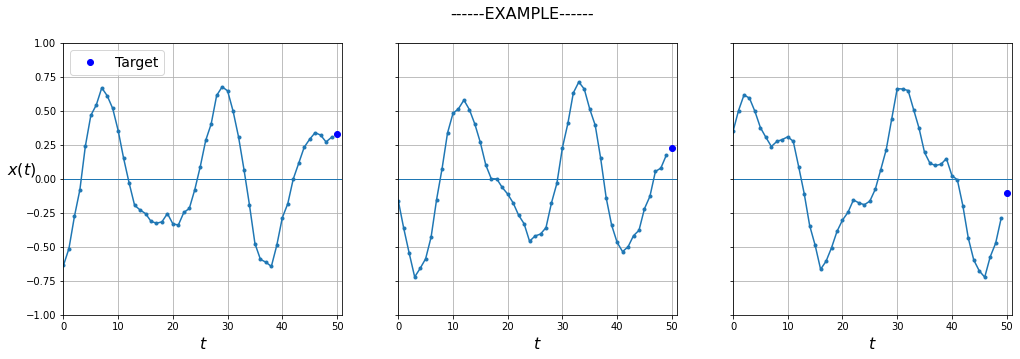

In [8]:
# Function for plot the timeseries - import directly from github book

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

        
# --------EXAMPLE--------------
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(17, 5))
fig.suptitle('------EXAMPLE------', fontsize=16)
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
# save_fig("time_series_plot")
plt.show()

## Baseline metrics

**What's baseline metrics?** Is a way to know about is our model is working great, we obtain a baseline metric to have and idea or else we may end up thinking our model works great when in fact it is doing worse than basic models. This is called *naive forecasting*, and it is sometimes surprisingly difficult to outperform. Another simple approach is to use a *fully connected network*

In [8]:
# Naive Forecasting

y_pred = X_valid[:, -1]
np.mean(tf.keras.losses.mean_squared_error(y_valid, y_pred))

0.019949378

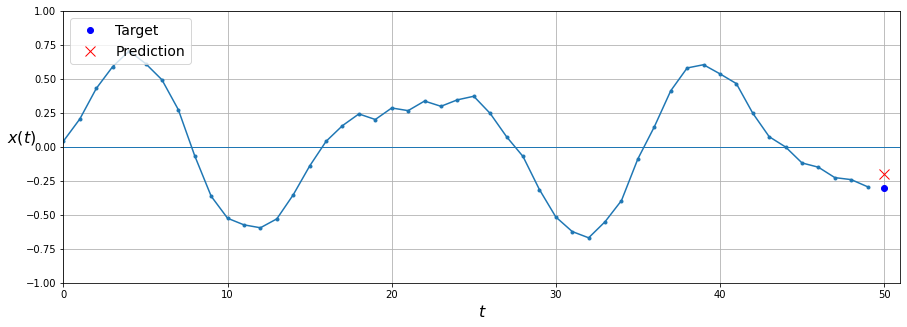

In [23]:
plt.figure(figsize=(15,5))
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0]) 
# X_valid[0, :, 0] -- Array of data with len of 50
# y_valid[0, 0] -- unic number from vector: -0.30216098
#  y_pred[0, 0] -- unic number from vector: -0.20113456
plt.show()

## Simple RNN: Forecast One point in future

In [49]:
'''
     We do not need to specify the length of the input sequences, since a recurrent neural 
     network can process any number of time steps (this is why we set the first input 
     dimension to None). By default, the SimpleRNN layer uses the hyperbolic
     tangent activation function.
'''

model_SimpleRNN = tf.keras.models.Sequential()
model_SimpleRNN.add(tf.keras.layers.SimpleRNN(1, input_shape=[None, 1]))
model_SimpleRNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [50]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model_SimpleRNN.compile(loss="mse", 
                        optimizer=optimizer,
                       metrics = ['accuracy'])
history_model_SimpleRNN = model_SimpleRNN.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 49s 213ms/step - loss: 0.0154 - accuracy: 0.0000e+00 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 45s 206ms/step - loss: 0.0113 - accuracy: 0.0000e+00 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 46s 211ms/step - loss: 0.0113 - accuracy: 0.0000e+00 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 46s 209ms/step - loss: 0.0113 - accuracy: 0.0000e+00 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 45s 205ms/step - loss: 0.0114 - accuracy: 0.0000e+00 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 46s 210ms/step - loss: 0.0113 - accuracy: 0.0000e+00 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 46s 210ms/step - loss: 0.011

In [51]:
model_SimpleRNN.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 11ms/step - loss: 0.0111 - accuracy: 0.0000e+00


[0.011127564124763012, 0.0]

In [17]:
# Function developep by me

def ResultsViz(history_model):
    x_range = len(history_model.history['accuracy'])

    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
    t = f.suptitle('Training and Validation Results', fontsize=17)
    f.subplots_adjust(top=0.85, wspace=0.2)

    epoch_list = list(range(1,x_range+1))
    ax1.plot(epoch_list, history_model.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history_model.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, x_range+1, 2))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history_model.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history_model.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, x_range+1, 2))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
    
    
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [62]:
# Function developep by author of the book
import matplotlib as mpl
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True)) # mlp is matplotlib as mpl - 
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

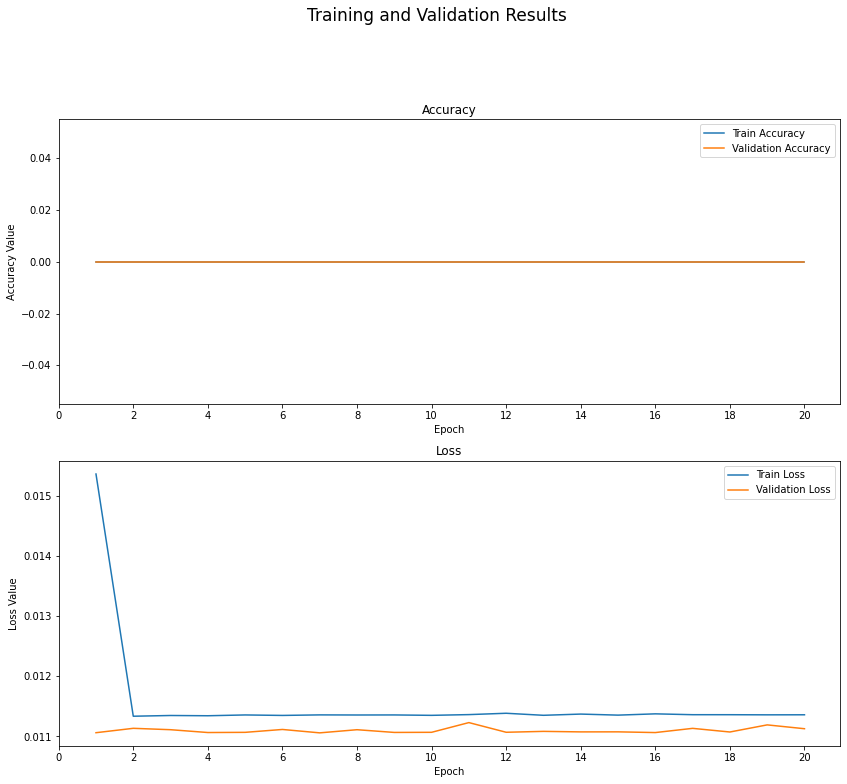

In [54]:
ResultsViz(history_model_SimpleRNN)

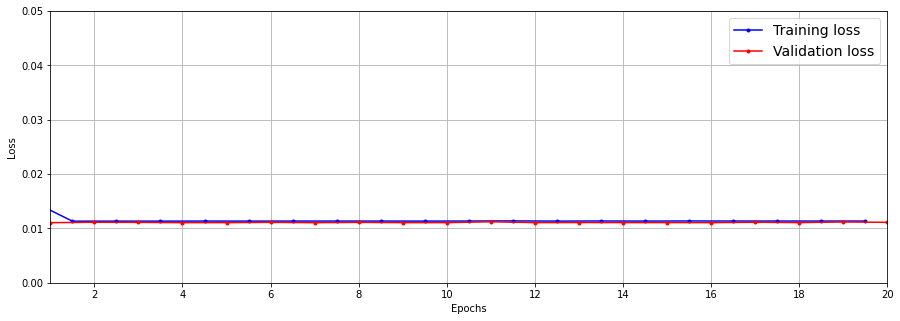

In [67]:
plt.figure(figsize=(15,5))
plot_learning_curves(history_model_SimpleRNN.history["loss"], history_model_SimpleRNN.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 10ms/step


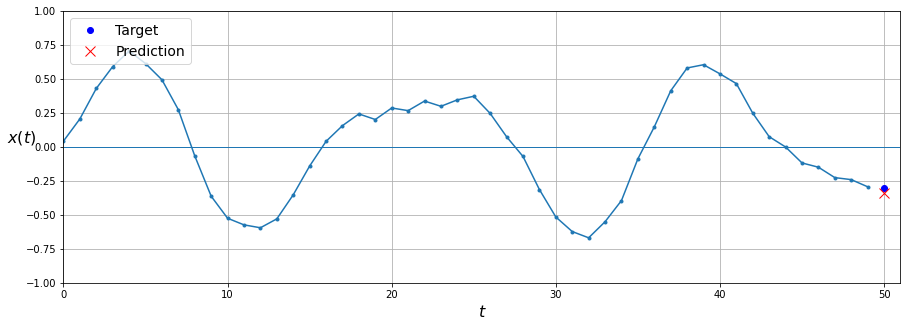

In [66]:
y_pred = model_SimpleRNN.predict(X_valid)
plt.figure(figsize=(15,5))
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNN: Forecast one point in the future 

In [69]:
'''
    Make sure to set return_sequences=True for all recurrent layers (except the last one, 
    if you only care about the last output). If you don’t, they will output a 2D array 
    (containing only the output of the last time step) instead of a 3D array (containing 
    outputs for all time steps), and the next recurrent layer will complain that you are 
    .not feeding it sequences in the expected 3D format.
'''


np.random.seed(42)
tf.random.set_seed(42)

model_Deep_RNN = tf.keras.models.Sequential()
model_Deep_RNN.add(tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]))
model_Deep_RNN.add(tf.keras.layers.SimpleRNN(20)) # Removed: return_sequences=True
# model_Deep_RNN.add(tf.keras.layers.SimpleRNN(1))
'''
    it must have a single unit because we want to forecast a univariate time series, and this 
    means we must have a single output value per time step. However, having a single unit means
    that the hidden state is just a single number. Moreover, since a SimpleRNN layer uses the tanh
    activation function by default, the predicted values must lie within the range –1 to 1. 
    
    
    For both these reasons, it might be preferable to replace the output layer with a Dense layer: 
    it would run slightly faster, the accuracy would be roughly the same, and it would allow us to 
    choose any output activation function we want. If you make this change, also make sure to remove 
    return_sequences=True from the second (now last)
'''
model_Deep_RNN.add(tf.keras.layers.Dense(1))
model_Deep_RNN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


In [70]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model_Deep_RNN.compile(loss="mse", 
                        optimizer=optimizer,
                       metrics = ['accuracy'])
history_model_Deep_RNN = model_Deep_RNN.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 25s 109ms/step - loss: 0.0114 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 24s 109ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 23s 107ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 24s 108ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0034 - val_accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 24s 109ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 24s 111ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 24s 109ms/step - loss: 0.003

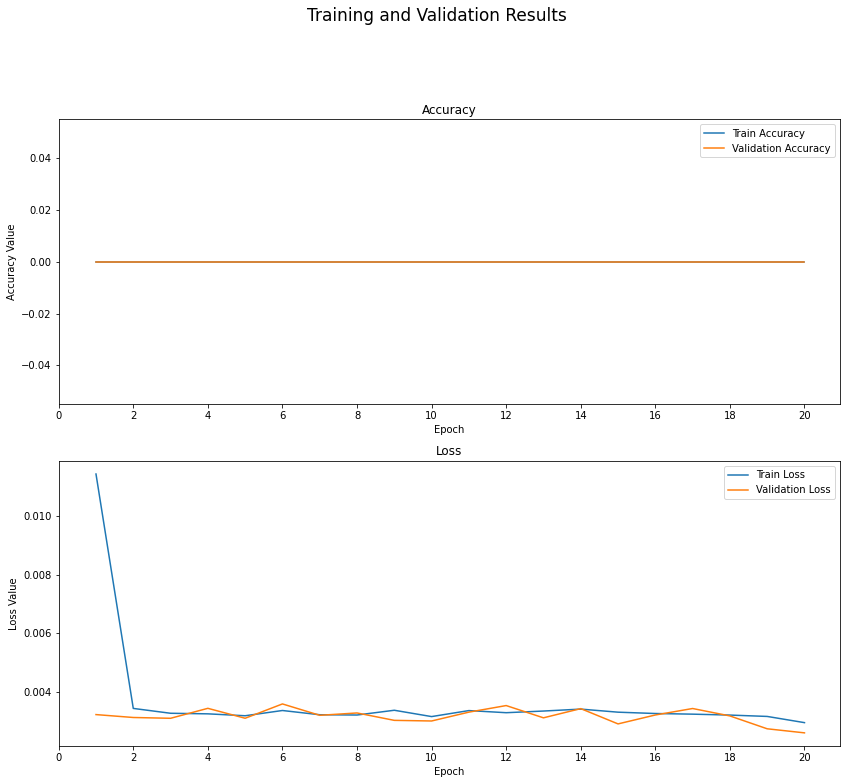

In [71]:
ResultsViz(history_model_Deep_RNN)

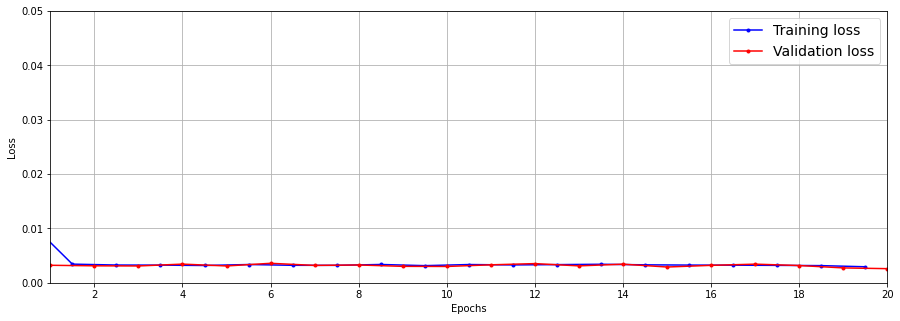

In [72]:
plt.figure(figsize=(15,5))
plot_learning_curves(history_model_Deep_RNN.history["loss"], history_model_Deep_RNN.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 20ms/step


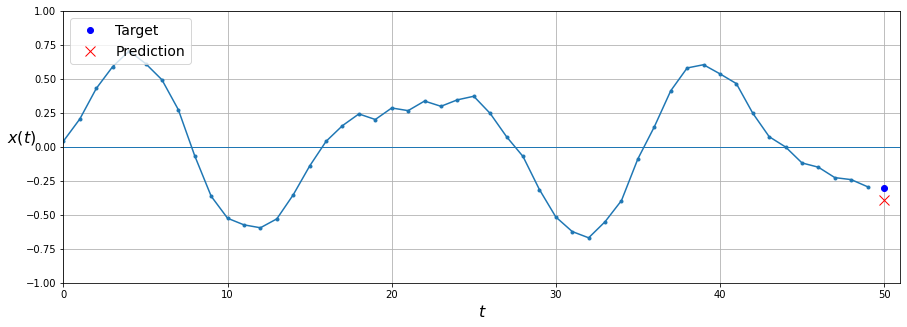

In [73]:
plt.figure(figsize=(15,5))
y_pred = model_Deep_RNN.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Deep RNN Single point: Forecast next 10 points

What's doing here? Forecasting point by point until arrive to 10 points?

*La primera opción es usar el modelo que ya entrenamos (model_Deep_RNN), hacer que prediga el siguiente valor, luego agregar ese valor a las entradas (actuando como si este valor predicho realmente hubiera ocurrido), y usar el modelo nuevamente para predecir el siguiente valor, y así sucesivamente, como en el siguiente código*

*La predicción para el siguiente paso generalmente será más precisa que las predicciones para los pasos de tiempo posteriores, ya que los errores pueden acumularse.*

In [75]:
np.random.seed(43) # not 42, as it would give the first series in the train set

# series = generate_time_series(10000, n_steps + 1) #(batch_size, n_steps)
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:] 
X = X_new
for step_ahead in range(10):
    y_pred_one = model_Deep_RNN.predict(X[:, step_ahead:])[:, np.newaxis, :] # Se realiza predición del siguiente step
    X = np.concatenate([X, y_pred_one], axis=1) # Agregando la prediccion a los datos

Y_pred = X[:, n_steps:]
Y_pred.shape

1/1 [==============================] - 0s 90ms/step


(1, 10, 1)

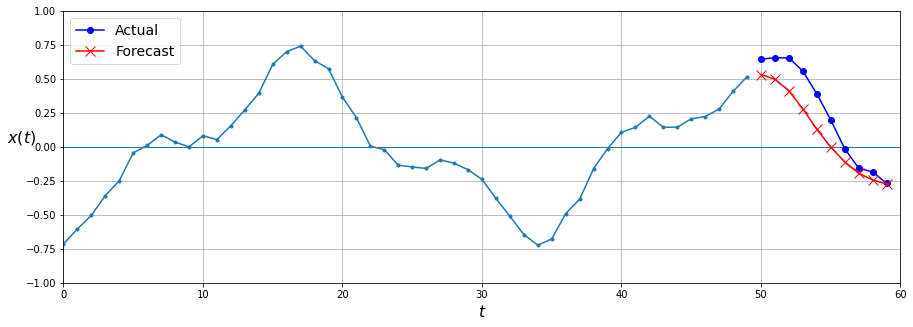

In [78]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plt.figure(figsize=(15,5))
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

*La segunda opción es entrenar un RNN para predecir los 10 valores siguientes a la vez. Todavía podemos usar un modelo de secuencia a vector, pero generará 10 valores en lugar de 1. Sin embargo, primero debemos cambiar los objetivos para que sean vectores que contengan **los siguientes 10 valores**:*

In [19]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0] # Contenga los siguientes 10 valores
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0] # Contenga los siguientes 10 valores
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0] # Contenga los siguientes 10 valores

*Ahora solo hace falta que la capa de salida de la red neuronal cuente con **10 unidades** de salida en vez de 1:*

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model_Deep_RNN_10points = tf.keras.models.Sequential()
model_Deep_RNN_10points.add(tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]))
model_Deep_RNN_10points.add(tf.keras.layers.SimpleRNN(20)) # Removed: return_sequences=True
model_Deep_RNN_10points.add(tf.keras.layers.Dense(10)) # 10 unidades a la salida en vez de 1
model_Deep_RNN_10points.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [22]:
optimizer = tf.keras.optimizers.Adam()
model_Deep_RNN_10points.compile(loss="mse", 
                        optimizer=optimizer)
history_model_Deep_RNN_10points = model_Deep_RNN_10points.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 131s 580ms/step - loss: 0.1587 - val_loss: 0.1471
Epoch 2/20
219/219 [==============================] - 126s 576ms/step - loss: 0.1464 - val_loss: 0.1458
Epoch 3/20
219/219 [==============================] - 124s 565ms/step - loss: 0.1461 - val_loss: 0.1455
Epoch 4/20
219/219 [==============================] - 127s 579ms/step - loss: 0.1458 - val_loss: 0.1457
Epoch 5/20
219/219 [==============================] - 126s 574ms/step - loss: 0.1458 - val_loss: 0.1456
Epoch 6/20
219/219 [==============================] - 126s 576ms/step - loss: 0.1456 - val_loss: 0.1455
Epoch 7/20
219/219 [==============================] - 126s 573ms/step - loss: 0.1456 - val_loss: 0.1456
Epoch 8/20
219/219 [==============================] - 123s 563ms/step - loss: 0.1456 - val_loss: 0.1454
Epoch 9/20
219/219 [==============================] - 126s 574ms/step - loss: 0.1456 - val_loss: 0.1456
Epoch 10/20
219/219 [==============================] - 124s 565m

In [31]:
np.random.seed(43)
# ------ ALERT!!! Cambiar model deep_rnn_10points -----
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model_Deep_RNN_10points.predict(X_new)[..., np.newaxis] 
# [..., np.newaxis] necesario para dimensiones y poder representar se obtiene vector 3D y buscamos uno 2D para poder representar

1/1 [==============================] - 0s 144ms/step


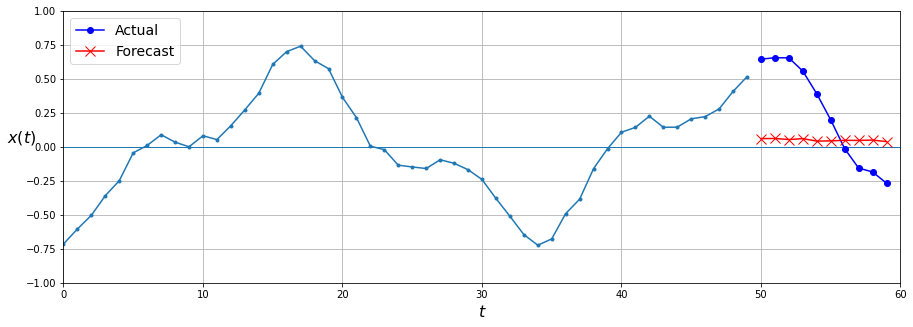

In [32]:
plt.figure(figsize=(15, 5))
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

**Porque realiza la predicción como una constante?** Investigar que puede ser, lo primero que se me ocurre es el reentrenamiento del mismo modelo, al hacer diversas pruebas es posible que el modelo se reentrene y se guarden algunos pesos y esto ocasione erroes en el entrenamiento, mejor entrenar sin haber entrenado nada antes a ver que resultados ofrece. Otra cosa a descartar es que no se trate de desvanecimiento del gradiente, quizas esto este ocurriendo y habria que solucionarlo si se detecta.

Ahora vamos a crear un RNN que prediga los siguientes 10 pasos en cada paso de tiempo. Es decir, en lugar de solo pronosticar los pasos de tiempo 50 a 59 con base en los pasos de tiempo 0 a 49, pronosticará los pasos de tiempo 1 a 10 en el paso de tiempo 0, luego los pasos de tiempo 2 a 11 en el paso de tiempo 1, y así sucesivamente, y finalmente pronosticará los pasos de tiempo 50 a 59 en el último paso de tiempo. Tenga en cuenta que el modelo es causal: cuando hace predicciones en cualquier paso de tiempo, solo puede ver pasos de tiempo pasados.

In [40]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
    # series[..., step] Para seleccionar todos los elementos de la primera fila
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model_Deep_RNN_10points_eachTime = tf.keras.models.Sequential()
model_Deep_RNN_10points_eachTime.add(tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]))
model_Deep_RNN_10points_eachTime.add(tf.keras.layers.SimpleRNN(20)) # Removed: return_sequences=True
model_Deep_RNN_10points_eachTime.add(tf.keras.layers.Dense(10)) # 10 unidades a la salida en vez de 1
model_Deep_RNN_10points_eachTime.summary()

def last_time_step_mse(Y_true, Y_pred):
    return tf.keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, None, 20)          440       
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 20)                820       
                                                                 
 dense_5 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_Deep_RNN_10points_eachTime.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history_model_Deep_RNN_10points_eachTime = model_Deep_RNN_10points_eachTime.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

## LSTM

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model_LSTM = tf.keras.models.Sequential()
model_LSTM.add(tf.keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]))
model_LSTM.add(tf.keras.layers.LSTM(20, return_sequences=True)) # Removed: return_sequences=True
model_LSTM.add(tf.keras.layers.Dense(10)) # 10 unidades a la salida en vez de 1
model_LSTM.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, None, 20)          1760      
                                                                 
 lstm_3 (LSTM)               (None, None, 20)          3280      
                                                                 
 dense_7 (Dense)             (None, None, 10)          210       
                                                                 
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_LSTM.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history_model_LSTM = model_LSTM.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 14ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0551 - val_last_time_step_mse: 0.0382
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0474 - last_time_step_mse: 0.0274 - val_loss: 0.0420 - val_last_time_step_mse: 0.0214
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0387 - last_time_step_mse: 0.0178 - val_loss: 0.0364 - val_last_time_step_mse: 0.0156
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0348 - last_time_step_mse: 0.0149 - val_loss: 0.0332 - val_last_time_step_mse: 0.0131
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0324 - last_time_step_mse: 0.0133 - val_loss: 0.0313 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0308 - last_time_step_mse: 0.0123 - val_loss: 0.0297 - val_last_time_step_mse: 0.0113
Epoch 7/20
219/219 [==

In [48]:
model_LSTM.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023760635405778885, 0.008572375401854515]

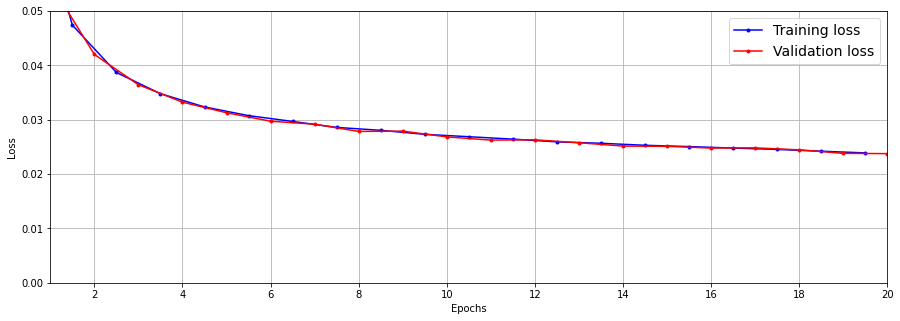

In [49]:
plt.figure(figsize=(15,5))
plot_learning_curves(history_model_LSTM.history["loss"], history_model_LSTM.history["val_loss"])
plt.show()

In [51]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10) #50 + 10?? For forecast 10 points in future?
X_new, Y_new = series[:, :50, :], series[:, 50:, :] # Take all data for 50 steps?
Y_pred = model_LSTM.predict(X_new)[:, -1][..., np.newaxis] # Make predicction 

1/1 [==============================] - 0s 461ms/step


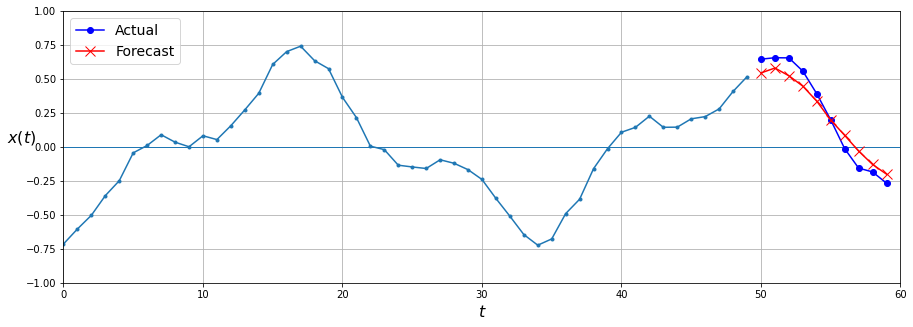

In [53]:
plt.figure(figsize=(15,5))
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## GRU

In [55]:
np.random.seed(42)
tf.random.set_seed(42)

model_GRU = tf.keras.models.Sequential()
model_GRU.add(tf.keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]))
model_GRU.add(tf.keras.layers.GRU(20, return_sequences=True)) # Removed: return_sequences=True
model_GRU.add(tf.keras.layers.Dense(10)) # 10 unidades a la salida en vez de 1
model_GRU.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 20)          1380      
                                                                 
 gru_1 (GRU)                 (None, None, 20)          2520      
                                                                 
 dense_9 (Dense)             (None, None, 10)          210       
                                                                 
Total params: 4,110
Trainable params: 4,110
Non-trainable params: 0
_________________________________________________________________


In [56]:
model_GRU.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history_model_GRU = model_GRU.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 12ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [=======

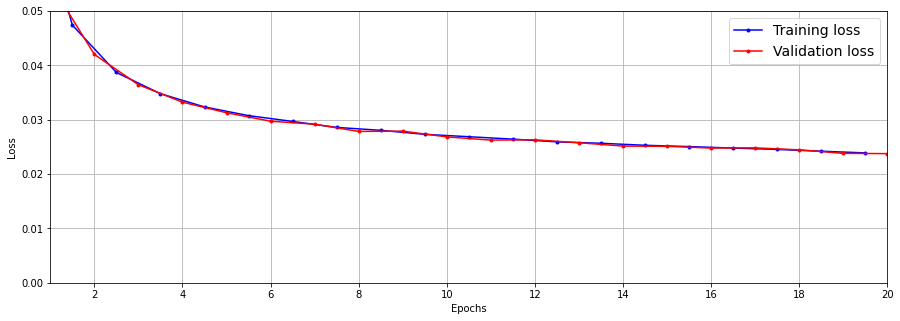

In [58]:
plt.figure(figsize=(15,5))
plot_learning_curves(history_model_LSTM.history["loss"], history_model_LSTM.history["val_loss"])
plt.show()

In [59]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10) #50 + 10?? For forecast 10 points in future?
X_new, Y_new = series[:, :50, :], series[:, 50:, :] # Take data to 50 points, the 10 next will be predict
Y_pred = model_GRU.predict(X_new)[:, -1][..., np.newaxis] # Make predicction 

1/1 [==============================] - 0s 371ms/step


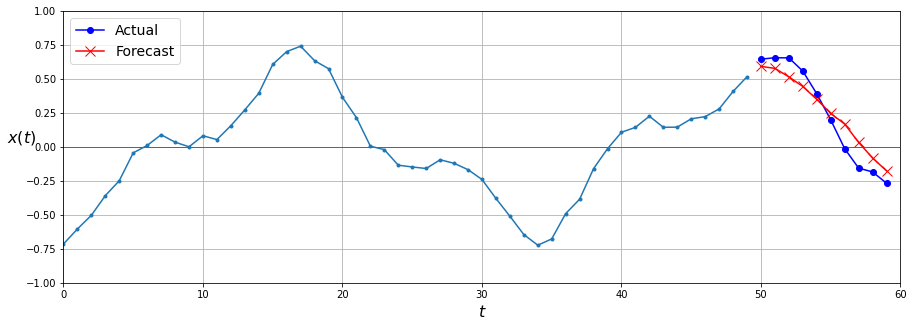

In [60]:
plt.figure(figsize=(15,5))
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()